In [13]:
import pandas as pd
import math
import numpy as np

from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import preprocess_data as ppd
import visualize as vs
import stock_data as sd


In [14]:
df = pd.read_csv('google.csv')
df

,Date,Open,High,Low,Close,Volume
0,30-Jun-17,943.99,945.00,929.61,929.68,2287662
1,29-Jun-17,951.35,951.66,929.60,937.82,3206674
2,28-Jun-17,950.66,963.24,936.16,961.01,2745568
3,27-Jun-17,961.60,967.22,947.09,948.09,2443602
4,26-Jun-17,990.00,993.99,970.33,972.09,1517912
...,...,...,...,...,...,...
3140,7-Jan-05,95.42,97.22,94.48,97.02,9666175
3141,6-Jan-05,97.72,98.05,93.95,94.37,10389803
3142,5-Jan-05,96.82,98.55,96.21,96.85,8239545
3143,4-Jan-05,100.77,101.57,96.84,97.35,13762396


In [15]:
stocks = ppd.remove_data(df)
stocks

,Item,Open,Close,Volume
0,0,98.80,101.46,15860692
1,1,100.77,97.35,13762396
2,2,96.82,96.85,8239545
3,3,97.72,94.37,10389803
4,4,95.42,97.02,9666175
...,...,...,...,...
3140,3140,990.00,972.09,1517912
3141,3141,961.60,948.09,2443602
3142,3142,950.66,961.01,2745568
3143,3143,951.35,937.82,3206674


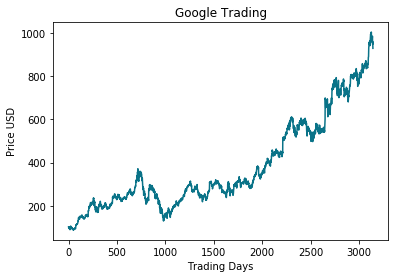

In [16]:

vs.plot_basic(stocks)


In [17]:
stocks = ppd.get_normalised_data(stocks)
print(stocks.head())

print("\n")
print("Open   --- mean :", np.mean(stocks['Open']),  "  \t Std: ", np.std(stocks['Open']),  "  \t Max: ", np.max(stocks['Open']),  "  \t Min: ", np.min(stocks['Open']))
print("Close  --- mean :", np.mean(stocks['Close']), "  \t Std: ", np.std(stocks['Close']), "  \t Max: ", np.max(stocks['Close']), "  \t Min: ", np.min(stocks['Close']))
print("Volume --- mean :", np.mean(stocks['Volume']),"  \t Std: ", np.std(stocks['Volume']),"  \t Max: ", np.max(stocks['Volume']),"  \t Min: ", np.min(stocks['Volume']))


   Item      Open     Close    Volume
0     0  0.012051  0.015141  0.377248
1     1  0.014198  0.010658  0.325644
2     2  0.009894  0.010112  0.189820
3     3  0.010874  0.007407  0.242701
4     4  0.008368  0.010298  0.224905


Open   --- mean : 0.3211922293886812   	 Std:  0.23261946808306658   	 Max:  0.9999999999999999   	 Min:  0.0
Close  --- mean : 0.3215558503465895   	 Std:  0.23283076112482215   	 Max:  1.0   	 Min:  0.0
Volume --- mean : 0.09061506381049182   	 Std:  0.09535947661989863   	 Max:  0.9999999999999999   	 Min:  0.0


In [18]:
null_value = stocks.isnull().sum()

null_value

Item      0
Open      0
Close     0
Volume    0
dtype: int64

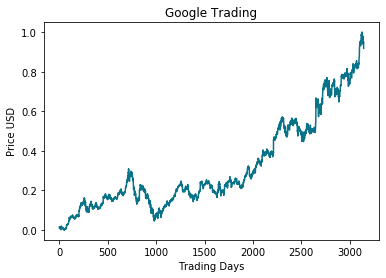

In [19]:
vs.plot_basic(stocks)


In [25]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import lstm, time #helper libraries

stocks_data = stocks.drop(['Item'], axis =1)


In [ ]:
X_train, X_test,y_train, y_test = sd.train_test_split_lstm(stocks_data, 5)

unroll_length = 50
X_train = sd.unroll(X_train, unroll_length)
X_test = sd.unroll(X_test, unroll_length)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)


In [27]:
# build basic lstm model
model = lstm.build_basic_model(input_dim = X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)


compilation time :  0.013615846633911133


In [28]:
model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_split=0.05)


77/77 [==============================] - 4s 56ms/step - loss: 0.0033 - val_loss: 3.2677e-04


In [29]:
predictions = model.predict(X_test)


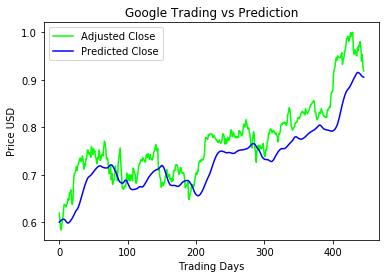

In [30]:
vs.plot_lstm_prediction(y_test,predictions)


In [31]:
# RMSE for Training-Testing Data with basic LSTM
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))


Train Score: 0.00038653 MSE (0.01966025 RMSE)
Test Score: 0.00263696 MSE (0.05135130 RMSE)


In [32]:
# Set up hyperparameters
batch_size = 100
epochs = 5

# build improved lstm model
model = lstm.build_improved_model( X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)


compilation time :  0.006129026412963867


In [33]:
model.fit(X_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )


Epoch 1/5
25/25 - 4s - loss: 0.0057 - val_loss: 0.0033
Epoch 2/5
25/25 - 3s - loss: 9.1170e-04 - val_loss: 2.7104e-04
Epoch 3/5
25/25 - 3s - loss: 7.9234e-04 - val_loss: 3.1560e-04
Epoch 4/5
25/25 - 2s - loss: 6.7558e-04 - val_loss: 7.0492e-04
Epoch 5/5
25/25 - 2s - loss: 6.5491e-04 - val_loss: 4.1618e-04


In [34]:
# Generate predictions 
predictions = model.predict(X_test, batch_size=batch_size)


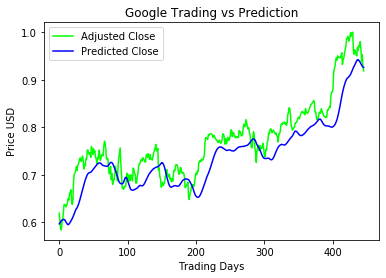

In [35]:
vs.plot_lstm_prediction(y_test,predictions)


In [36]:
# RMSE for Training-Testing Data with Improved LSTM
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))


Train Score: 0.00036682 MSE (0.01915255 RMSE)
Test Score: 0.00202777 MSE (0.04503078 RMSE)
